

PG53624-Ana Filipa da Cunha Rebelo
Visão Por Computador e Processamento de Imagem



Não consegui resolver o erro da função fit experimentei em tensorflow tambem estando num ficheiro a parte

In [5]:
%pip install kaggle tqdm pydot pillow torch torchvision torchsummary graphviz torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [9]:
import os


os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
os.system('cp kaggle.json ~/.kaggle/')

os.system('chmod 600 ~/.kaggle/kaggle.json')

256

In [8]:
# download  dataset Pix2Pix Facades
os.system('kaggle datasets download -d sabahesaraki/pix2pix-facades-dataset')

# unzip  dataset
os.system('unzip -q pix2pix-facades-dataset.zip -d pix2pix_facades')

0

Necessary Imports

In [58]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary
from PIL import Image
from glob import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchviz import make_dot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load Dataset

The dataset was loaded from Kaggle https://www.kaggle.com/datasets/sabahesaraki/pix2pix-facades-dataset

In [9]:
def load_image(path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    img = Image.open(path).convert('RGB')
    img = transform(img)
    return img

def load_images(root_path, img_format, trim=None):
    paths = sorted(glob(os.path.join(root_path, f"*.{img_format}")))
    if trim is not None:
        paths = paths[:trim]

    if not paths:
        raise RuntimeError(f"No images found in {root_path} with format {img_format}")

    images = []
    masks = []

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    for path in tqdm(paths, desc='Loading images'):
        try:
            img = Image.open(path).convert('RGB')
            img = transform(img)

            # Split a image into normal image and mask
            width = img.shape[2]
            half_width = width // 2

            img_normal = img[:, :, :half_width]  # Normal image on left side
            img_mask = img[:, :, half_width:]    # mask in the right side

            images.append(img_normal)
            masks.append(img_mask)
        except Exception as e:
            print(f"Error loading image {path}: {e}")

    if not images or not masks:
        raise RuntimeError("No images or masks loaded. Check if the image files are correct and the directories are not empty.")

    return torch.stack(images), torch.stack(masks)


train_path = 'pix2pix_facades/facades/train'
train_images, train_masks = load_images(train_path, img_format="jpg", trim=1000)

val_path = 'pix2pix_facades/facades/val'
val_images, val_masks = load_images(val_path, img_format="jpg", trim=100)

test_path = 'pix2pix_facades/facades/test'
test_images, test_masks = load_images(test_path, img_format="jpg", trim=100)

Loading images: 100%|██████████| 100/100 [00:00<00:00, 218.35it/s]


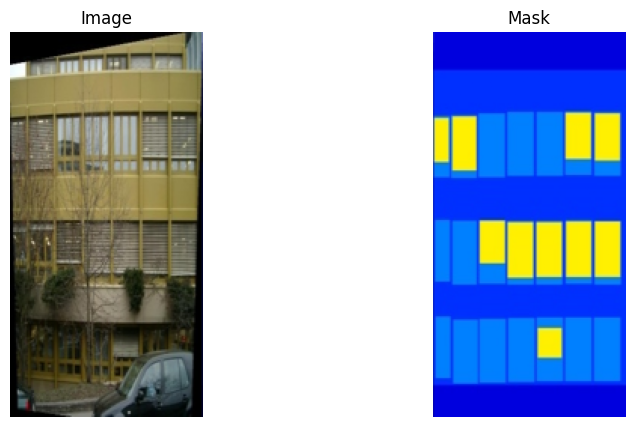

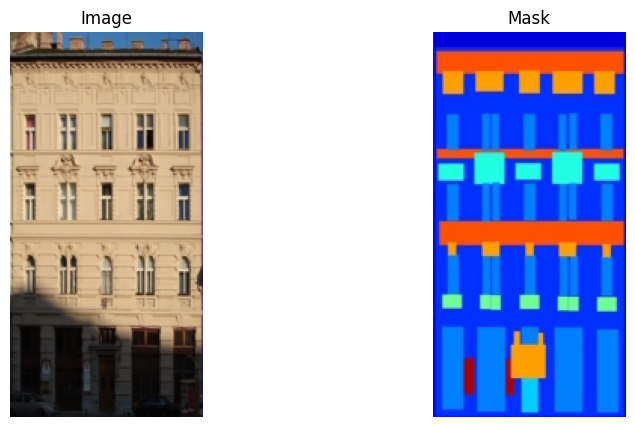

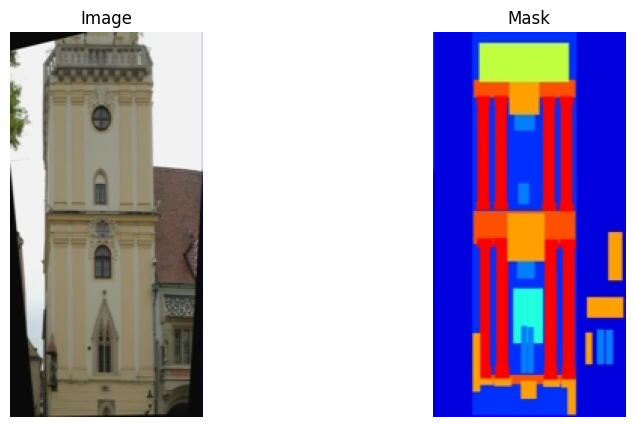

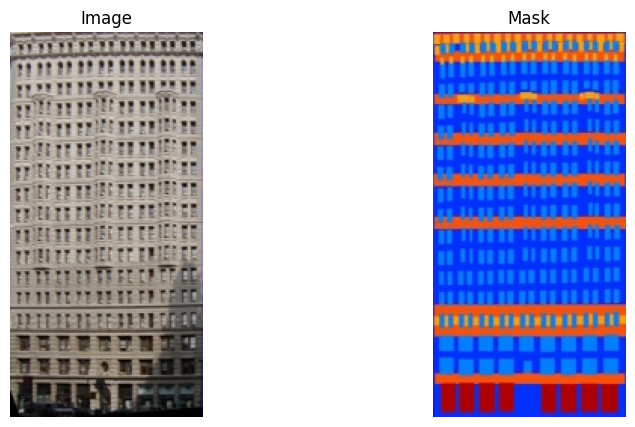

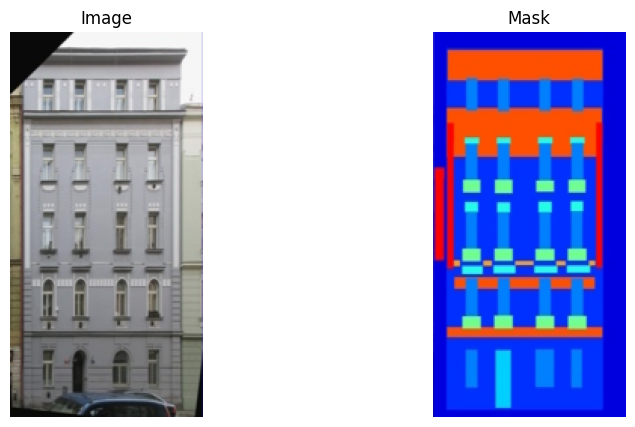

In [10]:
def show_images_and_masks(images, masks, num_images=5):
    indices = np.random.choice(len(images), num_images, replace=False)

    for idx in indices:
        image = images[idx].numpy().transpose((1, 2, 0))  # Convert tensor to numpy array and rearrange dimensions
        mask = masks[idx].numpy().transpose((1, 2, 0))    # Convert tensor to numpy array and rearrange dimensions

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.show()


show_images_and_masks(train_images, train_masks)


Pre-Processing

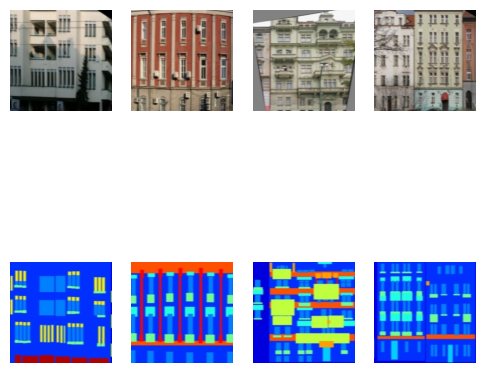

In [11]:
BUFFER_SIZE = 606
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Define transformations
resize = transforms.Resize((286, 286))
random_crop = transforms.RandomCrop((IMG_HEIGHT, IMG_WIDTH))
normalize = transforms.Normalize((0.5,), (0.5,))
horizontal_flip = transforms.RandomHorizontalFlip(p=0.5)

def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image = resize(input_image)
    real_image = resize(real_image)

    # Random cropping back to 256x256
    input_image = random_crop(input_image)
    real_image = random_crop(real_image)

    # Random mirroring
    if torch.rand(1) > 0.5:
        input_image = horizontal_flip(input_image)
        real_image = horizontal_flip(real_image)

    # Normalizing
    input_image = normalize(input_image)
    real_image = normalize(real_image)

    return input_image, real_image

def show_random_jitter_examples(images, masks, random_jitter_fn, num_examples=4):
    plt.figure(figsize=(6, 6))
    for i in range(num_examples):
        rj_inp, rj_re = random_jitter_fn(images[i], masks[i])

        # Denormalize to bring values back to range [0, 1]
        rj_inp = (rj_inp * 0.5) + 0.5
        rj_re = (rj_re * 0.5) + 0.5

        rj_inp = rj_inp.permute(1, 2, 0)  # Convert to HWC for plotting
        rj_re = rj_re.permute(1, 2, 0)    # Convert to HWC for plotting
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(rj_inp)
        plt.axis('off')
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(rj_re)
        plt.axis('off')

    plt.show()

show_random_jitter_examples(train_images, train_masks, random_jitter, num_examples=4)




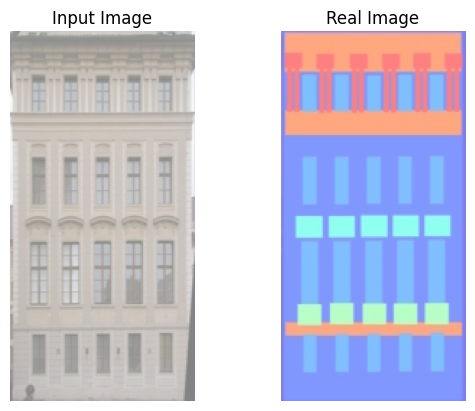

In [12]:
# Create TensorDatasets
train_dataset = TensorDataset(train_images, train_masks)
val_dataset = TensorDataset(val_images, val_masks)
test_dataset = TensorDataset(test_images, test_masks)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


for input_image, real_image in train_loader:
    input_image = input_image[0]  # Get the first image in the batch
    real_image = real_image[0]    # Get the first mask in the batch

    # Denormalize to bring values back to range [0, 1]
    input_image = (input_image * 0.5) + 0.5
    real_image = (real_image * 0.5) + 0.5

    # Convert to HWC for plotting
    input_image = input_image.permute(1, 2, 0)
    real_image = real_image.permute(1, 2, 0)

    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(real_image)
    plt.title('Real Image')
    plt.axis('off')

    plt.show()
    break  # Break after one batch for demonstration

Generator

In [13]:
OUTPUT_CHANNELS = 3

In [20]:
# Define the Downsample block
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_batchnorm=True):
        super(Downsample, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define the Upsample block
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_dropout=False):
        super(Upsample, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))
        layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define the Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.down_stack = nn.ModuleList([
            Downsample(3, 64, apply_batchnorm=False),   # (batch_size, 128, 128, 64)
            Downsample(64, 128),                        # (batch_size, 64, 64, 128)
            Downsample(128, 256),                       # (batch_size, 32, 32, 256)
            Downsample(256, 512),                       # (batch_size, 16, 16, 512)
            Downsample(512, 512),                       # (batch_size, 8, 8, 512)
            Downsample(512, 512),                       # (batch_size, 4, 4, 512)
            Downsample(512, 512),                       # (batch_size, 2, 2, 512)
            Downsample(512, 512),                       # (batch_size, 1, 1, 512)
        ])

        self.up_stack = nn.ModuleList([
            Upsample(512, 512, apply_dropout=True),     # (batch_size, 2, 2, 1024)
            Upsample(1024, 512, apply_dropout=True),    # (batch_size, 4, 4, 1024)
            Upsample(1024, 512, apply_dropout=True),    # (batch_size, 8, 8, 1024)
            Upsample(1024, 512),                        # (batch_size, 16, 16, 1024)
            Upsample(1024, 256),                        # (batch_size, 32, 32, 512)
            Upsample(512, 128),                         # (batch_size, 64, 64, 256)
            Upsample(256, 64),                          # (batch_size, 128, 128, 128)
        ])

        self.last = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False)  # Adjusted to output 3 channels

    def forward(self, x):
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = skips[:-1]  # remove the last skip connection

        skips = reversed(skips)

        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat((x, skip), dim=1)

        x = self.last(x)
        x = torch.tanh(x)
        return x



In [21]:
# Create an instance of the Generator model
generator = Generator()


summary(generator, (3, 256, 256))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
        Downsample-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         LeakyReLU-6          [-1, 128, 64, 64]               0
        Downsample-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
       BatchNorm2d-9          [-1, 256, 32, 32]             512
        LeakyReLU-10          [-1, 256, 32, 32]               0
       Downsample-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-13          [-1, 512, 16, 16]           1,024
        LeakyReLU-14          [-1, 512,

<ipython-input-24-bf99a9495d92>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(train_masks[0], dtype=torch.float32)


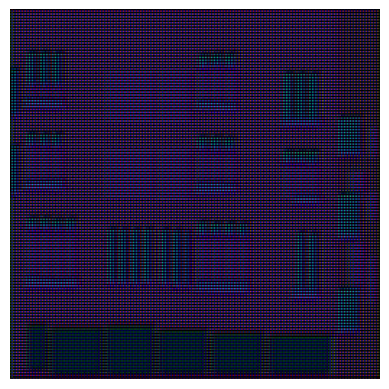

In [24]:

generator.eval()  # Set the model to evaluation mode

# Convert train_masks[0] to a PyTorch tensor and adjust dimensions
input_tensor = torch.tensor(train_masks[0], dtype=torch.float32)
input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension


input_tensor = torch.nn.functional.interpolate(input_tensor, size=(256, 256), mode='nearest')

with torch.no_grad():  # Disable gradient computation
    gen_output = generator(input_tensor)

# Convert output tensor to numpy array for plotting
gen_output = gen_output.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Clip the output to range [0, 1]
gen_output = np.clip(gen_output, 0.0, 1.0)

# Plot the generated output
plt.imshow(gen_output)
plt.axis('off')
plt.show()



Loss Functions

In [25]:
LAMBDA = 100

In [26]:
class BinaryFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(BinaryFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        # Convert targets to float
        targets = targets.float()

        # Compute the binary cross entropy term
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute the modulating factor
        modulating_factor = torch.exp(-self.gamma * targets * inputs.sigmoid() - self.gamma * torch.log1p(torch.exp(-inputs.abs())))

        # Combine the two terms and apply alpha
        focal_loss = (modulating_factor * bce_loss).mean()

        return focal_loss

In [27]:
def generator_loss(disc_generated_output, gen_output, target, loss_object, lambda_val):
    # Adversarial loss (Binary Cross Entropy with logits)
    gan_loss = F.binary_cross_entropy_with_logits(disc_generated_output, torch.ones_like(disc_generated_output))

    # Cast target to the same data type as gen_output
    target = target.to(gen_output.dtype)

    # Mean absolute error (L1 loss)
    l1_loss = F.l1_loss(gen_output, target)

    # Total generator loss
    total_gen_loss = gan_loss + (lambda_val * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [32]:

def downsample(in_channels, out_channels, size, apply_batchnorm=True):
    layers = [
        torch.nn.Conv2d(in_channels, out_channels, size, stride=2, padding=1, bias=False),
        torch.nn.BatchNorm2d(out_channels) if apply_batchnorm else torch.nn.Identity(),
        torch.nn.LeakyReLU(0.2, inplace=True)
    ]
    return torch.nn.Sequential(*layers)


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        initializer = torch.nn.init.normal_

        # layers downsampling
        self.down1 = downsample(6, 64, 4, False)  # (batch_size, 64, 128, 128)
        self.down2 = downsample(64, 128, 4)  # (batch_size, 128, 64, 64)
        self.down3 = downsample(128, 256, 4)  # (batch_size, 256, 32, 32)


        self.zero_pad1 = torch.nn.ZeroPad2d(1)
        self.conv = torch.nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=0, bias=False)
        self.batchnorm1 = torch.nn.BatchNorm2d(512)
        self.leaky_relu = torch.nn.LeakyReLU(0.2, inplace=True)
        self.zero_pad2 = torch.nn.ZeroPad2d(1)
        self.last = torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)

    def forward(self, inp, tar):
        # Pass through downsampling layers
        x = self.down1(torch.cat([inp, tar], dim=1))  # concatenate along channels dimension
        x = self.down2(x)
        x = self.down3(x)

        # Pass through zero-padding and convolution
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        x = self.last(x)

        return x



In [36]:
# Create an instance of the Discriminator model
discriminator = Discriminator()

# Create sample input tensors
sample_input1 = torch.rand((1, 3, 256, 256))
sample_input2 = torch.rand((1, 3, 256, 256))

# Visualize the model graph using torchviz and graphviz
viz_graph = make_dot(discriminator(sample_input1, sample_input2), params=dict(discriminator.named_parameters()))
viz_graph.render("discriminator_model", format="png", cleanup=True)


'discriminator_model.png'

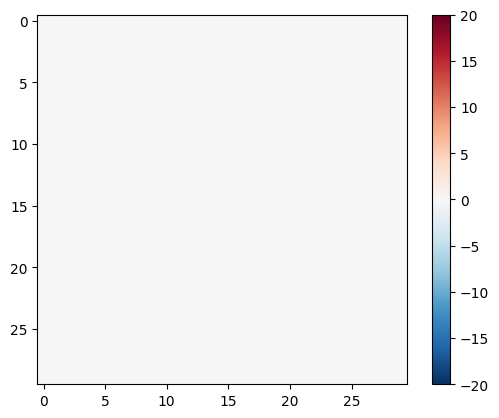

In [37]:

mask_tensor = train_masks[0].float().permute(2, 0, 1).unsqueeze(0)  # shape: (1, 3, 256, 128)
mask_tensor = torch.nn.functional.interpolate(mask_tensor, size=(256, 256), mode='bilinear', align_corners=False)
mask_tensor = mask_tensor[:, :3, :, :]


with torch.no_grad():
    gen_output = generator(mask_tensor)
    gen_output = gen_output[:, :3, :, :]


discriminator.eval()
with torch.no_grad():
    disc_out = discriminator(mask_tensor, gen_output)

plt.imshow(disc_out[0, 0].detach().cpu().numpy(), vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.show()



In [38]:
import torch
import torch.nn.functional as F

def discriminator_loss(disc_real_output, disc_generated_output):
    loss_object = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits


    real_loss = loss_object(torch.ones_like(disc_real_output), disc_real_output)


    generated_loss = loss_object(torch.zeros_like(disc_generated_output), disc_generated_output)


    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [40]:
import torch.optim as optim


generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")


def save_checkpoint(generator_optimizer, discriminator_optimizer, generator, discriminator, checkpoint_prefix):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = f"{checkpoint_prefix}.pth"
    torch.save({
        'generator_optimizer_state_dict': generator_optimizer.state_dict(),
        'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict(),
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint guardado em {checkpoint_path}")


def load_checkpoint(generator_optimizer, discriminator_optimizer, generator, discriminator, checkpoint_prefix):
    checkpoint_path = f"{checkpoint_prefix}.pth"
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        generator_optimizer.load_state_dict(checkpoint['generator_optimizer_state_dict'])
        discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
        print(f"Checkpoint carregado de {checkpoint_path}")
    else:
        print(f"Nenhum checkpoint encontrado em {checkpoint_path}")


save_checkpoint(generator_optimizer, discriminator_optimizer, generator, discriminator, checkpoint_prefix)


load_checkpoint(generator_optimizer, discriminator_optimizer, generator, discriminator, checkpoint_prefix)

Checkpoint guardado em ./training_checkpoints/ckpt.pth
Checkpoint carregado de ./training_checkpoints/ckpt.pth


In [41]:
def generate_images(model, test_input, tar):
    model.eval()
    with torch.no_grad():
        prediction = model(test_input)

    plt.figure(figsize=(15, 15))


    display_list = [test_input[0].cpu().numpy(), tar[0].cpu().numpy(), prediction[0].cpu().numpy()]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])

        plt.imshow(display_list[i].transpose(1, 2, 0) * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

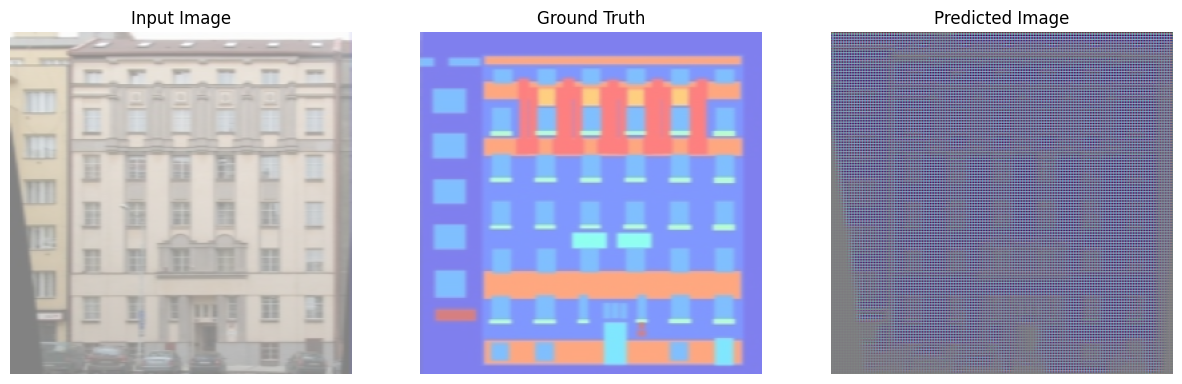

In [42]:

def resize_input(input_tensor, size=(256, 256)):
    return F.interpolate(input_tensor, size=size, mode='bilinear', align_corners=False)


for example_input, example_target in test_loader:
    example_input_resized = resize_input(example_input, size=(256, 256))
    example_target_resized = resize_input(example_target, size=(256, 256))

    generate_images(generator, example_input_resized, example_target_resized)
    break


Training

In [43]:
from torch.utils.tensorboard import SummaryWriter
import datetime


log_dir = "logs/"


os.makedirs(log_dir, exist_ok=True)


current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


summary_writer = SummaryWriter(log_dir + "fit/" + current_time)

In [44]:
def generator_loss(disc_generated_output, gen_output, target):
    criterion_gan = nn.BCEWithLogitsLoss()
    criterion_l1 = nn.L1Loss()

    gen_gan_loss = criterion_gan(disc_generated_output, torch.ones_like(disc_generated_output))
    gen_l1_loss = criterion_l1(gen_output, target)
    gen_total_loss = gen_gan_loss + (100 * gen_l1_loss)

    return gen_total_loss, gen_gan_loss, gen_l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    criterion = nn.BCEWithLogitsLoss()

    real_loss = criterion(disc_real_output, torch.ones_like(disc_real_output))
    generated_loss = criterion(disc_generated_output, torch.zeros_like(disc_generated_output))
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


In [45]:
def train_step(input_image, target, generator, discriminator, generator_optimizer, discriminator_optimizer, summary_writer, step):

    generator.train()
    discriminator.train()


    generator_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()

    # Forward pass
    gen_output = generator(input_image)

    disc_real_output = discriminator(torch.cat([input_image, target], dim=1))
    disc_generated_output = discriminator(torch.cat([input_image, gen_output.detach()], dim=1))


    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)


    gen_total_loss.backward()
    generator_optimizer.step()


    disc_loss.backward()
    discriminator_optimizer.step()


    if step % 1000 == 0:
        summary_writer.add_scalar('gen_total_loss', gen_total_loss.item(), step)
        summary_writer.add_scalar('gen_gan_loss', gen_gan_loss.item(), step)
        summary_writer.add_scalar('gen_l1_loss', gen_l1_loss.item(), step)
        summary_writer.add_scalar('disc_loss', disc_loss.item(), step)


In [151]:
def fit(train_loader, val_loader, generator, discriminator, generator_optimizer, discriminator_optimizer, steps, nz, device=torch.device('cpu')):
    criterion = nn.BCELoss()

    generator.to(device)
    discriminator.to(device)
    generator.train()
    discriminator.train()

    for step in range(steps):
        for real_data in train_loader:
            real_data = real_data[0].to(device)
            batch_size = real_data.size(0)

            # Train Discriminator
            discriminator.zero_grad()

            z = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_data = generator(z)

            label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
            output_real = discriminator(real_data)
            errD_real = criterion(output_real, label)
            errD_real.backward()

            label.fill_(0.)
            output_fake = discriminator(fake_data.detach())
            errD_fake = criterion(output_fake, label)
            errD_fake.backward()

            errD = errD_real + errD_fake
            discriminator_optimizer.step()

            # Train Generator
            generator.zero_grad()
            label.fill_(1.)
            output_gen = discriminator(fake_data)
            errG = criterion(output_gen, label)
            errG.backward()
            generator_optimizer.step()

        # Validation loop
        if step % 100 == 0:
            generator.eval()
            discriminator.eval()
            val_loss = 0.0
            val_batches = 0
            for val_data in val_loader:
                val_data = val_data[0].to(device)
                batch_size = val_data.size(0)

                z_val = torch.randn(batch_size, nz, 1, 1, device=device)
                fake_data_val = generator(z_val)

                label_val = torch.full((batch_size,), 1., dtype=torch.float, device=device)
                output_real_val = discriminator(val_data)
                errD_real_val = criterion(output_real_val, label_val)

                label_val.fill_(0.)
                output_fake_val = discriminator(fake_data_val.detach())
                errD_fake_val = criterion(output_fake_val, label_val)

                val_loss += errD_real_val.item() + errD_fake_val.item()
                val_batches += 1

            val_loss /= val_batches
            print(f"[Step {step}/{steps}] Loss_D: {errD.item()}, Loss_G: {errG.item()}, Val Loss_D: {val_loss}")

            generator.train()
            discriminator.train()

In [152]:
nz=100
steps = 10000


fit(train_loader, val_loader, generator, discriminator, generator_optimizer, discriminator_optimizer, steps, nz, device)

RuntimeError: Given groups=1, weight of size [64, 3, 4, 4], expected input[1, 100, 1, 1] to have 3 channels, but got 100 channels instead

In [128]:
for i, (inp, tar) in enumerate(test_loader):
    if i >= 5:
        break  # Interrompe após os primeiros 5 batches

    generate_images(generator, inp, tar)

RuntimeError: Calculated padded input size per channel: (4 x 3). Kernel size: (4 x 4). Kernel size can't be greater than actual input size